In [26]:
## module import
import pandas as pd
import numpy as np
from datetime import datetime
from pandas import DataFrame #데이터 전처리 

from statsmodels.tsa.seasonal import seasonal_decompose # decompose
from statsmodels.tsa.stattools import adfuller # stationary test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #AutoCorrelation , Partial AutoCorrelation
import itertools # 보간
from statsmodels.tsa.arima_model import ARIMA # SARIMA랑 다른 패키지
import statsmodels.api as sm # statsmodels


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [27]:
train = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/train.csv')
test = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/test.csv')
submission = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/submission.csv')

In [3]:
test.shape

(8760, 201)

In [28]:
test['Time'] = test['Time'].apply(pd.to_datetime)
test.set_index('Time',inplace=True)

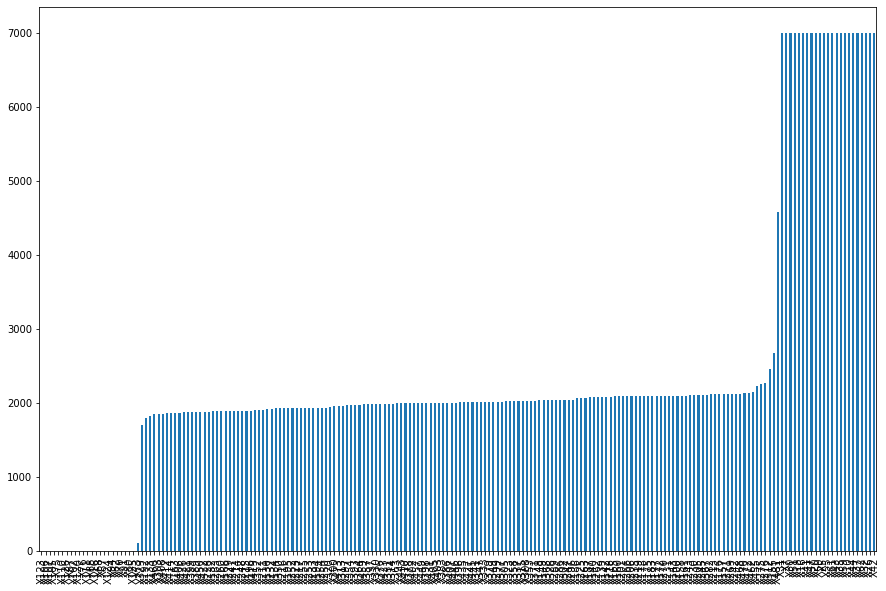

In [29]:
test.isnull().sum().sort_values(ascending=True).plot(kind='bar',figsize=(15,10))

In [30]:
## 결측치가 없는 세대
test.loc[:,test.isnull().sum()==0].columns

Index(['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107'],
      dtype='object')

In [31]:
# sample 데이터
test_sample = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']]

In [32]:
# 일
test_sample_day = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].resample(rule='D').sum()

# 월
test_sample_month = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].resample(rule='M').sum()

# 시간별
test_sample_hours = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']]

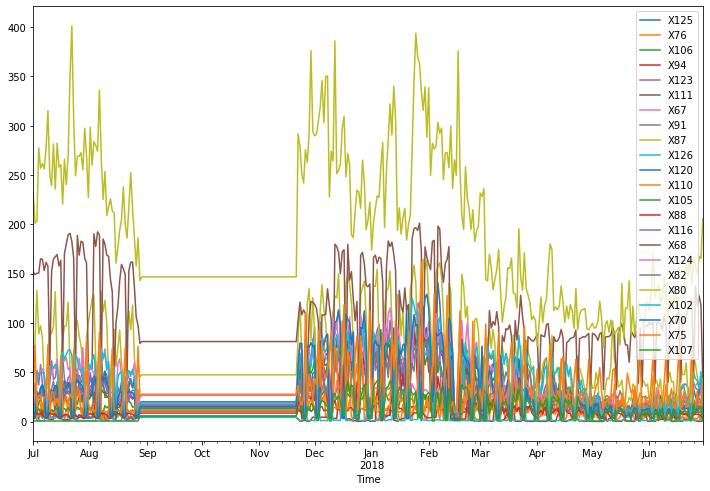

In [43]:
test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].resample(rule='D').sum().plot(figsize=(12,8))

In [48]:
test

,X26,X303,X241,X435,X402,X352,X305,X350,X326,X299,...,X283,X329,X223,X266,X20,X443,X347,X75,X107,X230
Time,,,,,,,,,,,,,,,,,,,,,
2017-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.275,0.021,NaN
2017-07-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.222,0.021,NaN
2017-07-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.237,0.021,NaN
2017-07-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.229,0.020,NaN
2017-07-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.202,0.021,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-30 19:00:00,1.255,0.175,0.430,0.429,0.169,0.739,0.573,0.341,0.127,0.286,...,0.312,0.381,0.479,0.858,11.546,0.428,0.134,3.519,0.027,0.286
2018-06-30 20:00:00,1.596,1.692,0.332,0.366,0.159,0.255,0.501,0.281,0.126,0.230,...,0.327,0.402,0.725,0.816,11.591,0.413,0.206,3.331,0.027,0.303
2018-06-30 21:00:00,1.379,0.883,0.435,0.497,0.166,0.233,0.634,0.401,0.439,0.346,...,0.253,0.401,0.426,0.659,10.766,0.466,0.324,3.416,0.026,0.253
